#### Objective:
This script implements **item-based collaborative filtering** to recommend movies similar to a target movie. The similarity is computed using **cosine similarity** on the movie-user ratings matrix.

#### Step 1: Movie-User Matrix
Construct the movie-user matrix $R \in \mathbb{R}^{m \times n}$, where:
- $m$: Number of movies
- $n$: Number of users
- $R_{ij}$: Rating given by user $j$ to movie $i$ (or $0$ if not rated).

#### Step 2: Cosine Similarity
The similarity $S_{ij}$ between movies $i$ and $j$ is computed as:
$S_{ij} = \frac{\vec{R}_i \cdot \vec{R}_j}{\|\vec{R}_i\| \|\vec{R}_j\|}$

Where:
- $\vec{R}_i$: Row vector representing ratings for movie $i$.
- $\|\vec{R}_i\|$: Euclidean norm of $\vec{R}_i$, given by $\sqrt{\sum_k R_{ik}^2}$.

#### Step 3: Similarity Scores for Target Movie
For a target movie $t$, compute:
$\text{Scores} = \{S_{tj} \,|\, j \neq t \}$

#### Step 4: Recommend Movies
Rank movies based on their similarity scores to the target movie and return the top $N$ recommendations.


Base Data Tables:
Movies Table: 9742 rows, 3 columns
Ratings Table: 100836 rows, 4 columns

Movies Table (Sample):
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings Table (Sample):
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Step 1: Creating Movie-User Matrix.

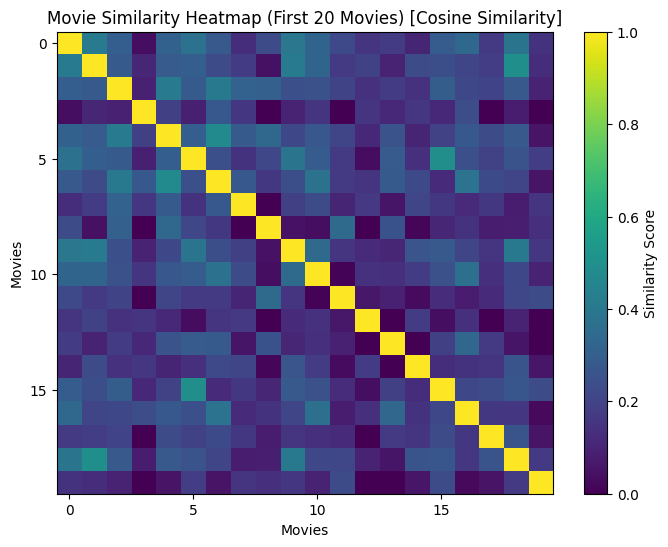


Step 4: Getting Similarity Scores for Movie ID 1...

Top Similar Movies:
movieId
1       1.000000
3114    0.572601
480     0.565637
780     0.564262
260     0.557388
356     0.547096
364     0.541145
1210    0.541089
648     0.538913
1265    0.534169
1270    0.530381
Name: 1, dtype: float64

Step 5: Recommending Movies Similar to the Target Movie...

Recommendations for Movies Similar to Toy Story (1995):
                                                     Movie  Similarity
movieId                                                               
3114                                    Toy Story 2 (1999)    0.572601
480                                   Jurassic Park (1993)    0.565637
780                   Independence Day (a.k.a. ID4) (1996)    0.564262
260              Star Wars: Episode IV - A New Hope (1977)    0.557388
356                                    Forrest Gump (1994)    0.547096
364                                  Lion King, The (1994)    0.541145
1210     Star Wars: Ep

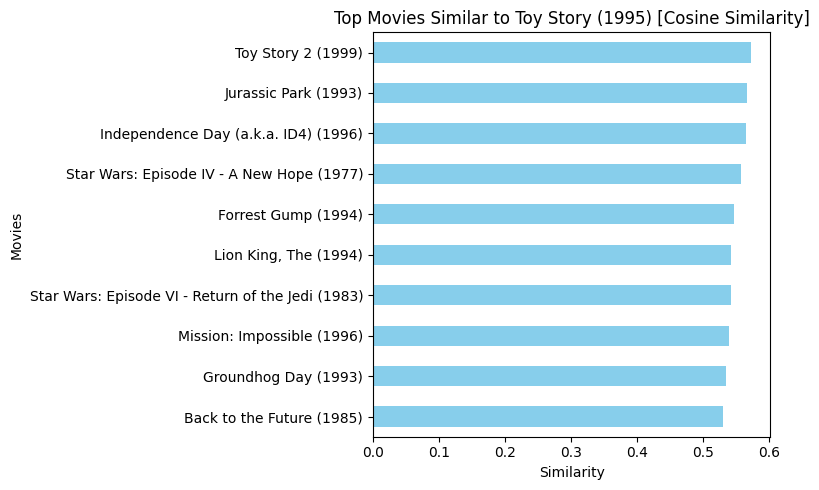

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Hyperparameters and Variables
path = 'data/ml-latest-small/'  # Path to dataset
movies_path = path + "movies.csv"
ratings_path = path + "ratings.csv"
movie_id = 1  # ID of the target movie (e.g., Toy Story (1995))
min_ratings = 0  # Minimum ratings to consider a movie (0 = no filtering)
similarity_metric = 'cosine'  # Metric for similarity ('cosine', 'pearson', 'jaccard')
top_n = 10  # Number of recommendations to return

# Load datasets
movies = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path)

# Describe base data tables
print("\nBase Data Tables:")
print(f"Movies Table: {movies.shape[0]} rows, {movies.shape[1]} columns")
print(f"Ratings Table: {ratings.shape[0]} rows, {ratings.shape[1]} columns")

# Display sample data
print("\nMovies Table (Sample):")
print(movies.head(5))
print("\nRatings Table (Sample):")
print(ratings.head(5))

# Step 1: Create a Movie-User Matrix
print("\nStep 1: Creating Movie-User Matrix...")
movie_user_matrix = ratings.pivot(index="movieId", columns="userId", values="rating")

# Step 2: Filter Movies Based on Minimum Ratings
if min_ratings > 0:
    print(f"\nFiltering movies with fewer than {min_ratings} ratings...")
    movie_counts = ratings.groupby("movieId").size()
    movie_user_matrix = movie_user_matrix.loc[movie_counts[movie_counts >= min_ratings].index]

# Display a sample of the Movie-User Matrix
print("Movie-User Matrix (First 5 Movies, First 5 Users):")
print(movie_user_matrix.iloc[:5, :5])

# Step 3: Fill Missing Values with 0
print("\nStep 2: Filling Missing Values with 0...")
movie_user_matrix = movie_user_matrix.fillna(0)

# Step 4: Compute Similarity Between Movies
print("\nStep 3: Computing Similarity Between Movies...")
if similarity_metric == 'cosine':
    movie_similarity = cosine_similarity(movie_user_matrix)
elif similarity_metric == 'pearson':
    movie_similarity = movie_user_matrix.T.corr().values  # Pearson correlation
elif similarity_metric == 'jaccard':
    binary_matrix = (movie_user_matrix > 0).astype(int)  # Convert to binary
    intersection = binary_matrix.dot(binary_matrix.T)
    row_sums = binary_matrix.sum(axis=1).values[:, None]
    union = row_sums + row_sums.T - intersection
    movie_similarity = intersection / union
else:
    raise ValueError(f"Unsupported similarity metric: {similarity_metric}")

similarity_df = pd.DataFrame(movie_similarity, index=movie_user_matrix.index, columns=movie_user_matrix.index)
print("\nMovie Similarity Matrix (First 5 Movies):")
print(similarity_df.iloc[:5, :5])

# Visualize movie similarity heatmap for a subset
print("\nVisualizing Movie Similarity Heatmap...")
plt.figure(figsize=(8, 6))
subset_similarity = similarity_df.iloc[:20, :20]
plt.imshow(subset_similarity, cmap="viridis", aspect="auto")
plt.colorbar(label="Similarity Score")
plt.title(f"Movie Similarity Heatmap (First 20 Movies) [{similarity_metric.capitalize()} Similarity]")
plt.xlabel("Movies")
plt.ylabel("Movies")
plt.xticks(range(0, 20, 5))
plt.yticks(range(0, 20, 5))
plt.show()

# Step 5: Get Similarity Scores for a Target Movie
print(f"\nStep 4: Getting Similarity Scores for Movie ID {movie_id}...")
target_movie_similarity = similarity_df[movie_id].sort_values(ascending=False)
print("\nTop Similar Movies:")
print(target_movie_similarity.head(top_n + 1))  # Include the target movie itself

# Step 6: Recommend Similar Movies
print("\nStep 5: Recommending Movies Similar to the Target Movie...")
top_similar_movies = target_movie_similarity.index[1:top_n + 1]  # Exclude the target movie itself

# Map movie IDs to titles and display with similarity weights
movie_titles = movies.set_index("movieId")["title"]
top_similar_movies_titles = pd.DataFrame({
    "Movie": movie_titles.loc[top_similar_movies],
    "Similarity": target_movie_similarity.loc[top_similar_movies]
})
print(f"\nRecommendations for Movies Similar to {movie_titles[movie_id]}:")
print(top_similar_movies_titles)

# Visualize Recommendations
print("\nVisualizing Recommendations...")
plt.figure(figsize=(8, 5))
top_similar_movies_titles.set_index("Movie")["Similarity"].plot(kind="barh", color="skyblue")
plt.title(f"Top Movies Similar to {movie_titles[movie_id]} [{similarity_metric.capitalize()} Similarity]")
plt.xlabel("Similarity")
plt.ylabel("Movies")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()